# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt_anchors.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

In [3]:
import numpy as np
import torch
img = torch.zeros((1, 3, 640, 640), dtype=torch.float32).to(device)
out = model([img, img])

In [4]:
out[0].shape

torch.Size([1, 3, 80, 80, 9])

In [5]:
out[0].shape

torch.Size([1, 3, 80, 80, 9])

In [6]:
anchors = model.model[-1].anchors

# [TODO] Draw anchors
anchors

tensor([[[2.75000, 5.37500],
         [3.12500, 7.12500],
         [5.87500, 6.25000]],

        [[2.06250, 4.62500],
         [2.62500, 5.68750],
         [2.93750, 7.18750]],

        [[1.90625, 4.40625],
         [5.65625, 1.68750],
         [2.50000, 6.31250]]])

## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

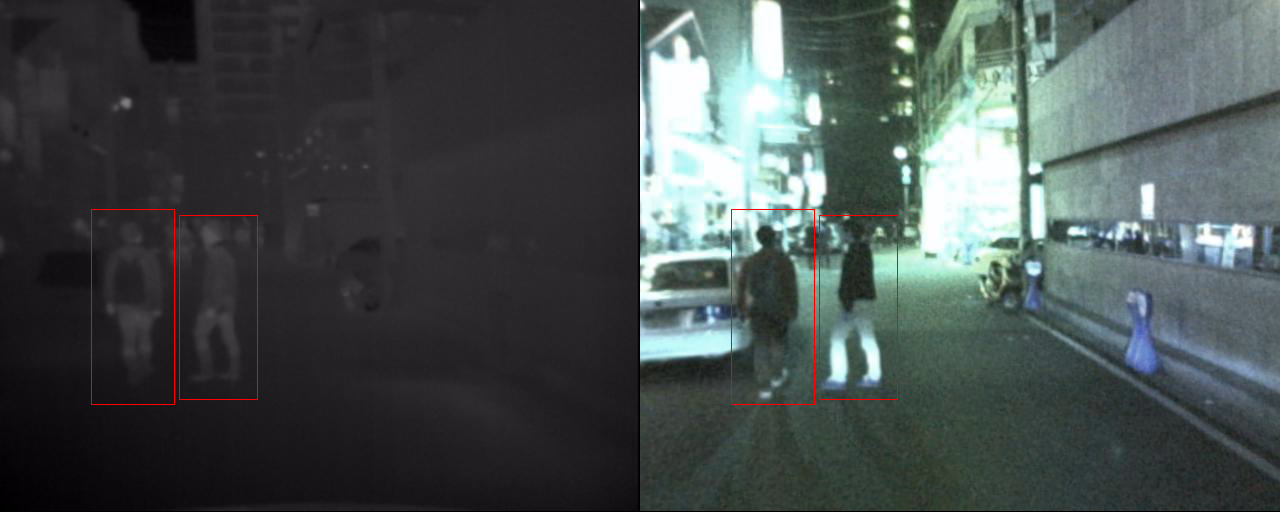

In [7]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [34]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)
q=0

train: Scanning /home/DL_PA2/datasets/kaist-rgbt/train.cache... 10538 images, 5873 backgrounds, 0 corrupt: 100%|██████████| 10538/10538 [00:00<?, ?it/s]


datasets/kaist-rgbt/train/images/{}/set00_V000_I00803.jpg


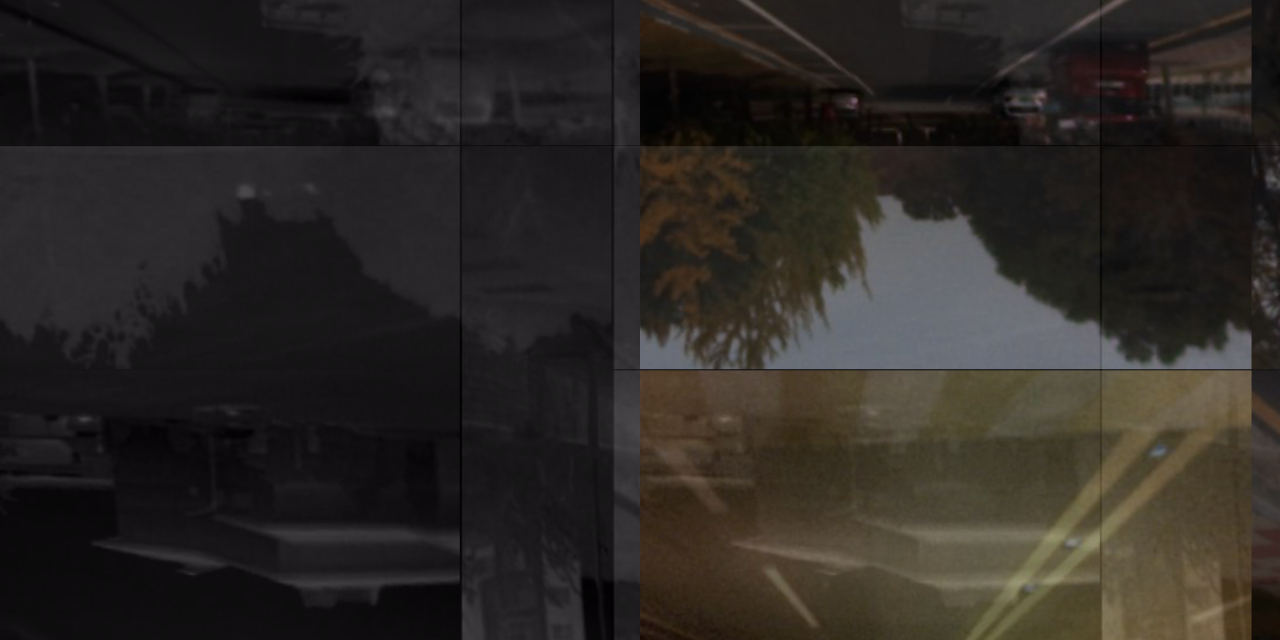

In [35]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 5000

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
# imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])
if q == 0:
    for _ in range(170):
        imgs, targets, paths, shapes, _ = next(iter(train_loader))
q += 1

imgs, targets, paths, shapes, _ = next(iter(train_loader))
idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()
colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

In [24]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 ddf4e91 Python-3.10.12 torch-2.0.1 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]  

YOLOv5s_kaist-rgbt summary: 248 layers, 7322824 parameters, 7322824 gradients



In [26]:
from utils.general import scale_boxes, non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# Resize predicted box
scale_boxes()         # see valpy:L285

# [TODO] draw predictions (see detect.py:L178)


In [27]:
pred[0]

tensor([], size=(0, 6))